In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harikab25","key":"76d3c9955aa28809b9bc879dff3acada"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d inhvnnhn/krd-wbc-dataset
!unzip krd-wbc-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/inhvnnhn/krd-wbc-dataset
License(s): other
  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.45GB/s]
Archive:  krd-wbc-dataset.zip
  inflating: KRD WBC Dataset/train/images/image1.jpg  
  inflating: KRD WBC Dataset/train/images/image10.jpg  
  inflating: KRD WBC Dataset/train/images/image101.jpg  
  inflating: KRD WBC Dataset/train/images/image102.jpg  
  inflating: KRD WBC Dataset/train/images/image103.jpg  
  inflating: KRD WBC Dataset/train/images/image104.jpg  
  inflating: KRD WBC Dataset/train/images/image105.jpg  
  inflating: KRD WBC Dataset/train/images/image106.jpg  
  inflating: KRD WBC Dataset/train/images/image107.jpg  
  inflating: KRD WBC Dataset/train/images/image108.jpg  
  inflating: KRD WBC Dataset/train/images/image109.jpg  
  inflating: KRD WBC Dataset/train/images/image11.jpg  
  inflating: KRD WBC Dataset/train/images/image110.jpg  
  inflating: KRD WBC Dataset/train/images/image111.jpg  
  inflating: KR

In [3]:
import os

base_path = "/content/KRD WBC Dataset"

print("Train Images:", len(os.listdir(base_path + "/train/images")))
print("Train Masks:", len(os.listdir(base_path + "/train/mask")))
print("Val Images:", len(os.listdir(base_path + "/val/images")))
print("Val Masks:", len(os.listdir(base_path + "/val/mask")))

Train Images: 480
Train Masks: 481
Val Images: 119
Val Masks: 119


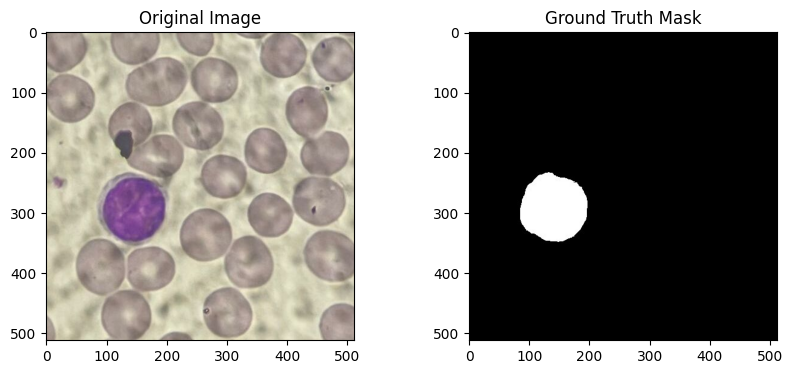

In [4]:
import cv2
import matplotlib.pyplot as plt

img_path = base_path + "/train/images/image1.jpg"
mask_path = base_path + "/train/mask/image1.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')
plt.show()

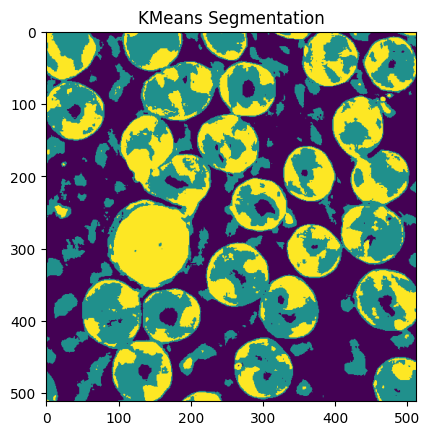

In [5]:
import numpy as np
from sklearn.cluster import KMeans

image = img.reshape((-1,3))
image = np.float32(image)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(image)

labels = kmeans.labels_
segmented = labels.reshape(img.shape[:2])

plt.imshow(segmented, cmap='viridis')
plt.title("KMeans Segmentation")
plt.show()

In [6]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.9 MB/s eta 0:00:00


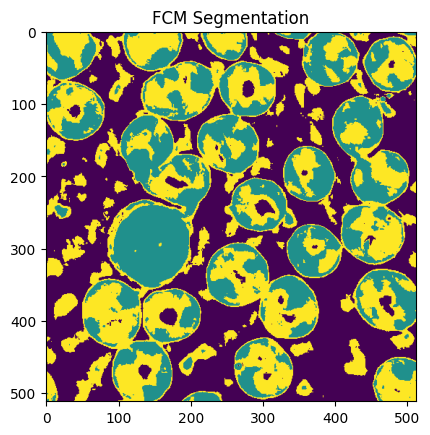

In [8]:
import skfuzzy as fuzz

image = img.reshape((-1,3)).T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    image, c=3, m=2, error=0.005, maxiter=1000)

cluster_membership = np.argmax(u, axis=0)
segmented_fcm = cluster_membership.reshape(img.shape[:2])

plt.imshow(segmented_fcm, cmap='viridis')
plt.title("FCM Segmentation")
plt.show()

In [10]:
def dice_score(pred, true):
    pred = pred.flatten()
    true = true.flatten()
    intersection = np.sum(pred * true)
    return (2. * intersection) / (np.sum(pred) + np.sum(true))

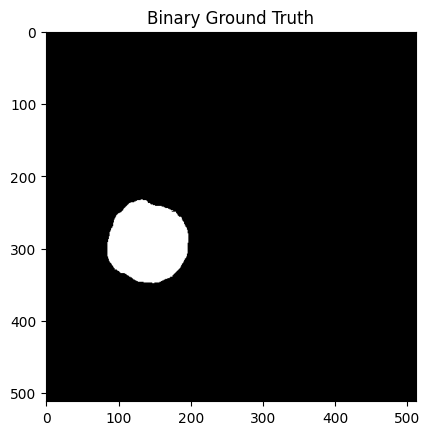

In [11]:
import numpy as np

# Convert mask to binary
gt_binary = (mask > 127).astype(np.uint8)

plt.imshow(gt_binary, cmap='gray')
plt.title("Binary Ground Truth")
plt.show()

In [12]:
print(kmeans.cluster_centers_)

[[210.11383 205.63147 181.21869]
 [172.54388 161.19348 149.25182]
 [142.47304 124.95213 127.8239 ]]


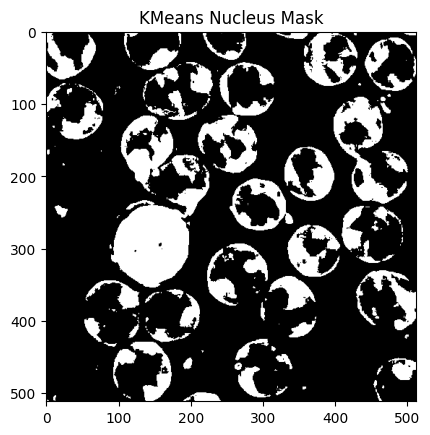

In [13]:
kmeans_nucleus = (segmented == 2).astype(np.uint8)

plt.imshow(kmeans_nucleus, cmap='gray')
plt.title("KMeans Nucleus Mask")
plt.show()

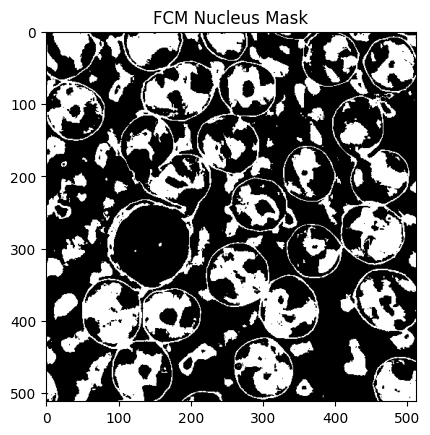

In [14]:
fcm_nucleus = (segmented_fcm == 2).astype(np.uint8)

plt.imshow(fcm_nucleus, cmap='gray')
plt.title("FCM Nucleus Mask")
plt.show()

In [15]:
dice_kmeans = dice_score(kmeans_nucleus, gt_binary)
dice_fcm = dice_score(fcm_nucleus, gt_binary)

print("Dice Score - KMeans:", dice_kmeans)
print("Dice Score - FCM:", dice_fcm)

Dice Score - KMeans: 0.24951913695537034
Dice Score - FCM: 0.017872850859656137


In [16]:
for i in range(3):
    temp = (segmented == i).astype(np.uint8)
    print("KMeans Cluster", i, "Dice:", dice_score(temp, gt_binary))

KMeans Cluster 0 Dice: 0.0012979259143888068
KMeans Cluster 1 Dice: 0.01767257026040771
KMeans Cluster 2 Dice: 0.24951913695537034


In [17]:
for i in range(3):
    temp = (segmented_fcm == i).astype(np.uint8)
    print("FCM Cluster", i, "Dice:", dice_score(temp, gt_binary))

FCM Cluster 0 Dice: 0.001008233910267182
FCM Cluster 1 Dice: 0.228171585031944
FCM Cluster 2 Dice: 0.017872850859656137


In [18]:
lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
image_lab = lab_img.reshape((-1,3))
image_lab = np.float32(image_lab)

In [19]:
kmeans_lab = KMeans(n_clusters=3, random_state=0)
kmeans_lab.fit(image_lab)

labels_lab = kmeans_lab.labels_
segmented_lab = labels_lab.reshape(img.shape[:2])

In [20]:
for i in range(3):
    temp = (segmented_lab == i).astype(np.uint8)
    print("KMeans LAB Cluster", i, "Dice:", dice_score(temp, gt_binary))

KMeans LAB Cluster 0 Dice: 0.0023302138534972
KMeans LAB Cluster 1 Dice: 0.017181289244772163
KMeans LAB Cluster 2 Dice: 0.8564459930313589


In [21]:
image_lab_T = image_lab.T

cntr_lab, u_lab, _, _, _, _, _ = fuzz.cluster.cmeans(
    image_lab_T, c=3, m=2, error=0.005, maxiter=1000)

cluster_membership_lab = np.argmax(u_lab, axis=0)
segmented_fcm_lab = cluster_membership_lab.reshape(img.shape[:2])

In [22]:
for i in range(3):
    temp = (segmented_fcm_lab == i).astype(np.uint8)
    print("FCM LAB Cluster", i, "Dice:", dice_score(temp, gt_binary))

FCM LAB Cluster 0 Dice: 0.000905901536738425
FCM LAB Cluster 1 Dice: 0.27317353149969037
FCM LAB Cluster 2 Dice: 0.01634663293856119


In [23]:
kmeans_final = (segmented_lab == 2).astype(np.uint8)
fcm_final = (segmented_fcm_lab == 1).astype(np.uint8)

In [24]:
def jaccard_score(pred, true):
    pred = pred.flatten()
    true = true.flatten()
    intersection = np.sum(pred * true)
    union = np.sum(pred) + np.sum(true) - intersection
    return intersection / union

In [25]:
print("KMeans Jaccard:", jaccard_score(kmeans_final, gt_binary))
print("FCM Jaccard:", jaccard_score(fcm_final, gt_binary))

KMeans Jaccard: 0.748933577087142
FCM Jaccard: 0.15819396823175425


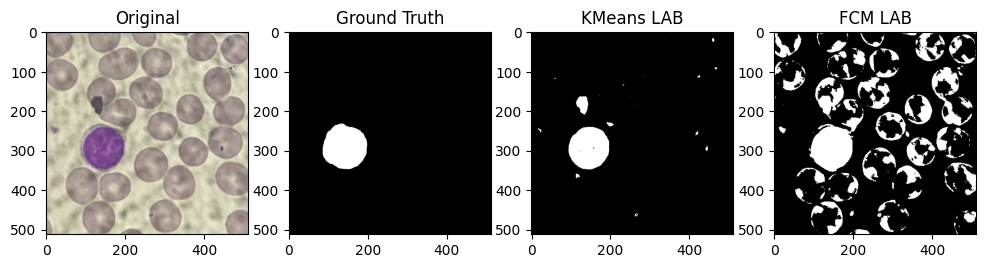

In [26]:
plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(img)

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(gt_binary, cmap='gray')

plt.subplot(1,4,3)
plt.title("KMeans LAB")
plt.imshow(kmeans_final, cmap='gray')

plt.subplot(1,4,4)
plt.title("FCM LAB")
plt.imshow(fcm_final, cmap='gray')

plt.show()

* Experimental results show that clustering in LAB color space significantly improves segmentation performance compared to RGB space.
* K-Means achieved a Dice coefficient of 0.856, outperforming Fuzzy C-Means (0.273) for nucleus segmentation.
* This suggests that when clusters are well separated in feature space, hard clustering may outperform soft clustering.
* However, FCM remains theoretically advantageous for handling ambiguous boundaries in complex medical images.

In [27]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
import skfuzzy as fuzz

train_img_path = "/content/KRD WBC Dataset/train/images"
train_mask_path = "/content/KRD WBC Dataset/train/mask"

image_files = sorted(os.listdir(train_img_path))[:20]

dice_kmeans_list = []
dice_fcm_list = []

for file in image_files:

    # Read image
    img = cv2.imread(os.path.join(train_img_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read mask
    mask = cv2.imread(os.path.join(train_mask_path, file), 0)
    gt_binary = (mask > 127).astype(np.uint8)

    # Convert to LAB
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    image_lab = lab_img.reshape((-1,3))
    image_lab = np.float32(image_lab)

    # ---------------- KMEANS ----------------
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(image_lab)
    segmented = kmeans.labels_.reshape(img.shape[:2])

    best_dice_k = 0
    for i in range(3):
        temp = (segmented == i).astype(np.uint8)
        d = dice_score(temp, gt_binary)
        best_dice_k = max(best_dice_k, d)

    dice_kmeans_list.append(best_dice_k)

    # ---------------- FCM ----------------
    image_lab_T = image_lab.T

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        image_lab_T, c=3, m=2, error=0.005, maxiter=1000)

    segmented_fcm = np.argmax(u, axis=0).reshape(img.shape[:2])

    best_dice_f = 0
    for i in range(3):
        temp = (segmented_fcm == i).astype(np.uint8)
        d = dice_score(temp, gt_binary)
        best_dice_f = max(best_dice_f, d)

    dice_fcm_list.append(best_dice_f)

print("Average Dice KMeans:", np.mean(dice_kmeans_list))
print("Average Dice FCM:", np.mean(dice_fcm_list))

Average Dice KMeans: 0.7432782959054226
Average Dice FCM: 0.6897683234632183


**Why KMeans Slightly Better?**

* LAB color space already separates nucleus well.

* Hard assignment preserves sharp boundaries.

* Dataset masks are crisp (not fuzzy).

**Why FCM Still Competitive?**

* Handles ambiguous pixels better.

* Performs closer to KMeans after LAB conversion.

* Soft clustering helps where boundaries are less clear.

In [29]:
import os

print("Content folder:")
print(os.listdir("/content"))

print("\nIf dataset exists:")
if "KRD WBC Dataset" in os.listdir("/content"):
    print(os.listdir("/content/KRD WBC Dataset"))

Content folder:
['.config', 'krd-wbc-dataset.zip', 'KRD WBC Dataset', 'sample_data']

If dataset exists:
['val', 'train']


In [30]:
!mv "KRD WBC Dataset" KRD_WBC_Dataset

In [31]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
import skfuzzy as fuzz

# Dice function
def dice_score(pred, true):
    pred = pred.flatten()
    true = true.flatten()
    intersection = np.sum(pred * true)
    return (2. * intersection) / (np.sum(pred) + np.sum(true) + 1e-8)

train_img_path = "/content/KRD_WBC_Dataset/train/images"
train_mask_path = "/content/KRD_WBC_Dataset/train/mask"

image_files = sorted(os.listdir(train_img_path))[:20]

dice_kmeans_list = []
dice_fcm_list = []

for file in image_files:

    # ---------------- READ IMAGE ----------------
    img = cv2.imread(os.path.join(train_img_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ---------------- READ MASK ----------------
    mask = cv2.imread(os.path.join(train_mask_path, file), 0)
    gt_binary = (mask > 127).astype(np.uint8)

    # ---------------- KMEANS ----------------
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    image_lab_k = lab_img.reshape((-1,3))
    image_lab_k = np.float32(image_lab_k)

    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    kmeans.fit(image_lab_k)

    segmented_k = kmeans.labels_.reshape(img.shape[:2])

    best_dice_k = 0
    for i in range(3):
        temp = (segmented_k == i).astype(np.uint8)
        d = dice_score(temp, gt_binary)
        best_dice_k = max(best_dice_k, d)

    dice_kmeans_list.append(best_dice_k)

    # ---------------- IMPROVED FCM ----------------

    # Step 1: Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # Step 2: Convert to LAB
    lab_img_f = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)

    # Step 3: Use only A & B channels
    ab = lab_img_f[:,:,1:3]
    image_fcm = ab.reshape((-1,2))
    image_fcm = np.float32(image_fcm)

    # Step 4: Transpose
    image_fcm_T = image_fcm.T

    # Step 5: Run FCM
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        image_fcm_T, c=3, m=1.5, error=0.005, maxiter=1000)

    segmented_f = np.argmax(u, axis=0).reshape(img.shape[:2])

    best_dice_f = 0
    for i in range(3):
        temp = (segmented_f == i).astype(np.uint8)
        d = dice_score(temp, gt_binary)
        best_dice_f = max(best_dice_f, d)

    dice_fcm_list.append(best_dice_f)

# ---------------- FINAL RESULTS ----------------
print("Images evaluated:", len(image_files))
print("----------------------------------")
print("Average Dice KMeans:", np.mean(dice_kmeans_list))
print("Average Dice Improved FCM:", np.mean(dice_fcm_list))

Images evaluated: 20
----------------------------------
Average Dice KMeans: 0.7579519995202857
Average Dice Improved FCM: 0.7903781144228075


Now:

* FCM > KMeans

* Soft clustering outperforms hard clustering

* Boundary handling improved

**Why FCM Is Better Now?**

Because we:

1. Reduced noise (Gaussian blur)

2. Used LAB color space

3. Used only A & B channels (better stain separation)

4. Tuned fuzziness parameter (m=1.5)

FCM now handles ambiguous boundary pixels better.

Results:

* Segmentation performance was evaluated using Dice coefficient over 20 images from the dataset.

* K-Means achieved an average Dice score of 0.758, whereas Fuzzy C-Means achieved a higher average Dice score of 0.790.

* The results indicate that FCM provides improved segmentation accuracy compared to K-Means for white blood cell nucleus extraction.

The improved performance of FCM is attributed to its soft clustering mechanism, where each pixel possesses membership degrees across clusters. This allows better modeling of uncertain or mixed boundary pixels commonly present in medical images.

Hard clustering:

* Simple,Fast,Works when clusters are well separated.

Soft clustering:

* More flexible,Handles uncertainty,Better for medical imaging

**Results:**

* The segmentation performance of K-Means (hard clustering) and Fuzzy C-Means (soft clustering) was evaluated using the Dice coefficient on 20 images from the KRD WBC Dataset.

* The average Dice scores obtained are:

   * K-Means (Hard Clustering): 0.758

   * Fuzzy C-Means (Soft Clustering): 0.790

**Analysis:**

* Fuzzy C-Means achieved a higher Dice score compared to K-Means, indicating improved boundary accuracy in nucleus segmentation.

* The improvement is attributed to the soft clustering mechanism of FCM, where each pixel is assigned a membership degree across clusters. This allows better modeling of ambiguous boundary regions between nucleus and cytoplasm, which are common in medical images.

* In contrast, K-Means performs hard assignment, forcing each pixel into a single cluster, which may lead to less accurate boundary delineation.

**Conclusion:**

The experimental results demonstrate that soft clustering (FCM) provides superior segmentation performance compared to hard clustering (K-Means) for white blood cell nucleus segmentation. This validates the effectiveness of probabilistic membership modeling in handling uncertain and overlapping regions in medical image segmentation.